## Библиотека LightGBM

In [123]:
import pandas as pd
import numpy as np
from sklearn import datasets

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook as tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

%matplotlib inline

In [124]:
def encode_option(a):
    if a == 'econom':
        return 1
    if a == 'business':
        return 2
    if a == 'vip':
        return 3
    else:
        return 0

# Обработаем данные
Добавим признаки со временем и датой, сумму по классам и самое важное количество заказов в час, в радиусе 120 метров, в одну дату

Лишнее удаляем

In [125]:
train = pd.read_csv('train_data.csv')
target = pd.read_csv('train_target.csv')
test = pd.read_csv('test_data.csv')

train['target'] = target

In [126]:
array = []
for data in tqdm_notebook((train, test)):
    
    data.loc[:,'time_as_str'] = data['due'].apply(lambda x: x[x.find(' ') + 1:-4])
    data.loc[:, 'time_in_seconds'] = pd.to_timedelta(data['time_as_str']).dt.total_seconds()
    
    data['due'] = pd.to_datetime(data['due'])
    data['date'] = data['due'].dt.date
    data['hour'] = data['due'].dt.hour
    data['weekday'] = data['due'].dt.weekday
    
    for method in ('date', 'hour','weekday', 'minute', 'month'):
        data[method] = getattr(data['due'].dt, method)
    
    for option in ('f', 's', 't'):
        data[option] = data.loc[:, option + '_class'].apply(encode_option)
    data['sum'] = data['f'] + data['s'] + data['t']

    array.append(data.copy(deep = True))


In [127]:
arr =[]

train, test = array[0], array[1]
for data in (train, test):
    for coords in ('lat', 'lon'):
        data[coords + '_round'] = round(data[coords],3)
    data['index'] = data.index 
    
    df = data.groupby(['lat_round','lon_round', 'date', 'hour'], as_index = False).agg({'index': 'count'})
    df = pd.DataFrame(df)
    data_ = pd.merge(data, df,  how='left', left_on=['lat_round','lon_round', 'date', 'hour'],
                      right_on = ['lat_round','lon_round', 'date', 'hour'])
    
    data_.drop(['date','time_as_str','hour', 'due',
               't', 'f', 's', 'f_class', 's_class', 't_class'], axis=1, inplace=True)
    
    arr.append(data_.copy(deep = True))

train, test = arr[0], arr[1]

In [128]:
test.columns

Index(['dist', 'lat', 'lon', 'time_in_seconds', 'weekday', 'minute', 'month',
       'sum', 'lat_round', 'lon_round', 'index_x', 'index_y'],
      dtype='object')

# Кластеризация 

In [129]:
def clust(train, test):
    model = KMeans(n_clusters=40, n_jobs=-1)
    model.fit(train[['lat', 'lon']])
    
    for data in (train, test):
        data['clust'] =  model.predict(data[['lat', 'lon']])
        data['dist_clust'] = model.transform(data[['lat', 'lon']]).min(axis=1)
    
    plt.scatter(test.loc[:, 'lon'], test.loc[:, 'lat'], c=test['clust'], cmap='viridis')
    centers = model.cluster_centers_
    plt.scatter(centers[:, 1], centers[:, 0], c='black', alpha=0.5)


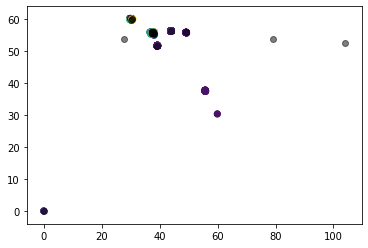

In [130]:
clust(train, test)

In [131]:
feature_columns = train.columns.tolist()
feature_columns.pop(feature_columns.index('target'))

target_column = ['target']

# Модель

In [132]:
train__, val__ = train_test_split(train, test_size = 0.3)

In [133]:
train__

,dist,lat,lon,target,time_in_seconds,weekday,minute,month,sum,lat_round,lon_round,index_x,index_y,clust,dist_clust
194600,20680.600694,55.677915,37.702382,0,49200.0,5,40,3,1,55.678,37.702,194600,1,15,0.057288
818251,3229.342455,55.764273,37.564410,0,41700.0,6,35,1,1,55.764,37.564,818251,1,19,0.015463
121437,5368.768686,55.660958,37.467520,0,0.0,6,0,1,2,55.661,37.468,121437,1,27,0.002792
952353,6122.960049,55.753083,37.587614,0,54600.0,4,10,2,6,55.753,37.588,952353,1,14,0.016946
336339,12962.574821,55.761016,37.621336,0,3600.0,6,0,1,1,55.761,37.621,336339,1,14,0.017946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801396,6226.291871,55.759365,37.572091,0,72300.0,1,5,1,3,55.759,37.572,801396,1,19,0.015587
778925,41618.768403,55.527300,37.149326,1,59700.0,3,35,1,1,55.527,37.149,778925,1,25,0.179124
728684,47062.278098,55.414327,37.900470,0,9000.0,2,30,1,1,55.414,37.900,728684,4,12,0.005704
420958,7372.063112,55.713040,37.500944,0,51000.0,0,10,1,1,55.713,37.501,420958,1,30,0.008155


In [134]:
from lightgbm import LGBMClassifier 

clf = LGBMClassifier(n_estimators=1000, learning_rate=0.05, num_leaves=63)
clf.fit(
    train__[feature_columns], train__[target_column].values.ravel(),
    eval_set=[(val__[feature_columns], val__[target_column].values.ravel())],
    eval_metric='auc',
    verbose=True,
    early_stopping_rounds=200,
)

[1]	valid_0's auc: 0.707707	valid_0's binary_logloss: 0.409479
Training until validation scores don't improve for 200 rounds
[2]	valid_0's auc: 0.70988	valid_0's binary_logloss: 0.40547
[3]	valid_0's auc: 0.710743	valid_0's binary_logloss: 0.402019
[4]	valid_0's auc: 0.711135	valid_0's binary_logloss: 0.399021
[5]	valid_0's auc: 0.712215	valid_0's binary_logloss: 0.396372
[6]	valid_0's auc: 0.712968	valid_0's binary_logloss: 0.394009
[7]	valid_0's auc: 0.713931	valid_0's binary_logloss: 0.391875
[8]	valid_0's auc: 0.714361	valid_0's binary_logloss: 0.390005
[9]	valid_0's auc: 0.714718	valid_0's binary_logloss: 0.388287
[10]	valid_0's auc: 0.715429	valid_0's binary_logloss: 0.386778
[11]	valid_0's auc: 0.715635	valid_0's binary_logloss: 0.385392
[12]	valid_0's auc: 0.715797	valid_0's binary_logloss: 0.38414
[13]	valid_0's auc: 0.716786	valid_0's binary_logloss: 0.382991
[14]	valid_0's auc: 0.71722	valid_0's binary_logloss: 0.381958
[15]	valid_0's auc: 0.717438	valid_0's binary_logloss: 

[131]	valid_0's auc: 0.727416	valid_0's binary_logloss: 0.366445
[132]	valid_0's auc: 0.727463	valid_0's binary_logloss: 0.366431
[133]	valid_0's auc: 0.727478	valid_0's binary_logloss: 0.366422
[134]	valid_0's auc: 0.727481	valid_0's binary_logloss: 0.36642
[135]	valid_0's auc: 0.727489	valid_0's binary_logloss: 0.366415
[136]	valid_0's auc: 0.727502	valid_0's binary_logloss: 0.366404
[137]	valid_0's auc: 0.727517	valid_0's binary_logloss: 0.366395
[138]	valid_0's auc: 0.727538	valid_0's binary_logloss: 0.366377
[139]	valid_0's auc: 0.727566	valid_0's binary_logloss: 0.366357
[140]	valid_0's auc: 0.727586	valid_0's binary_logloss: 0.366352
[141]	valid_0's auc: 0.727583	valid_0's binary_logloss: 0.366353
[142]	valid_0's auc: 0.727599	valid_0's binary_logloss: 0.366337
[143]	valid_0's auc: 0.727613	valid_0's binary_logloss: 0.36633
[144]	valid_0's auc: 0.727635	valid_0's binary_logloss: 0.366321
[145]	valid_0's auc: 0.72766	valid_0's binary_logloss: 0.366308
[146]	valid_0's auc: 0.72767

[260]	valid_0's auc: 0.728975	valid_0's binary_logloss: 0.365452
[261]	valid_0's auc: 0.728972	valid_0's binary_logloss: 0.365452
[262]	valid_0's auc: 0.728979	valid_0's binary_logloss: 0.365445
[263]	valid_0's auc: 0.728981	valid_0's binary_logloss: 0.365445
[264]	valid_0's auc: 0.728977	valid_0's binary_logloss: 0.365446
[265]	valid_0's auc: 0.729003	valid_0's binary_logloss: 0.365436
[266]	valid_0's auc: 0.729009	valid_0's binary_logloss: 0.365432
[267]	valid_0's auc: 0.729021	valid_0's binary_logloss: 0.365423
[268]	valid_0's auc: 0.729021	valid_0's binary_logloss: 0.365423
[269]	valid_0's auc: 0.729043	valid_0's binary_logloss: 0.365417
[270]	valid_0's auc: 0.729042	valid_0's binary_logloss: 0.365415
[271]	valid_0's auc: 0.729047	valid_0's binary_logloss: 0.365412
[272]	valid_0's auc: 0.729045	valid_0's binary_logloss: 0.365414
[273]	valid_0's auc: 0.729048	valid_0's binary_logloss: 0.36541
[274]	valid_0's auc: 0.729058	valid_0's binary_logloss: 0.365404
[275]	valid_0's auc: 0.729

[389]	valid_0's auc: 0.729667	valid_0's binary_logloss: 0.365019
[390]	valid_0's auc: 0.729661	valid_0's binary_logloss: 0.365022
[391]	valid_0's auc: 0.729674	valid_0's binary_logloss: 0.365019
[392]	valid_0's auc: 0.729678	valid_0's binary_logloss: 0.365013
[393]	valid_0's auc: 0.72968	valid_0's binary_logloss: 0.365011
[394]	valid_0's auc: 0.729685	valid_0's binary_logloss: 0.365006
[395]	valid_0's auc: 0.729695	valid_0's binary_logloss: 0.365005
[396]	valid_0's auc: 0.729697	valid_0's binary_logloss: 0.365004
[397]	valid_0's auc: 0.729711	valid_0's binary_logloss: 0.365002
[398]	valid_0's auc: 0.729724	valid_0's binary_logloss: 0.364999
[399]	valid_0's auc: 0.729734	valid_0's binary_logloss: 0.364995
[400]	valid_0's auc: 0.729737	valid_0's binary_logloss: 0.364992
[401]	valid_0's auc: 0.729739	valid_0's binary_logloss: 0.364992
[402]	valid_0's auc: 0.729749	valid_0's binary_logloss: 0.364987
[403]	valid_0's auc: 0.729751	valid_0's binary_logloss: 0.364982
[404]	valid_0's auc: 0.729

[518]	valid_0's auc: 0.730214	valid_0's binary_logloss: 0.364685
[519]	valid_0's auc: 0.730204	valid_0's binary_logloss: 0.364687
[520]	valid_0's auc: 0.73021	valid_0's binary_logloss: 0.364682
[521]	valid_0's auc: 0.730209	valid_0's binary_logloss: 0.364682
[522]	valid_0's auc: 0.730207	valid_0's binary_logloss: 0.364683
[523]	valid_0's auc: 0.730208	valid_0's binary_logloss: 0.364684
[524]	valid_0's auc: 0.73021	valid_0's binary_logloss: 0.364683
[525]	valid_0's auc: 0.730206	valid_0's binary_logloss: 0.364681
[526]	valid_0's auc: 0.730207	valid_0's binary_logloss: 0.364681
[527]	valid_0's auc: 0.730202	valid_0's binary_logloss: 0.364682
[528]	valid_0's auc: 0.730201	valid_0's binary_logloss: 0.364682
[529]	valid_0's auc: 0.730196	valid_0's binary_logloss: 0.364684
[530]	valid_0's auc: 0.730199	valid_0's binary_logloss: 0.364682
[531]	valid_0's auc: 0.7302	valid_0's binary_logloss: 0.364682
[532]	valid_0's auc: 0.730197	valid_0's binary_logloss: 0.364683
[533]	valid_0's auc: 0.730199

[645]	valid_0's auc: 0.730479	valid_0's binary_logloss: 0.364513
[646]	valid_0's auc: 0.730485	valid_0's binary_logloss: 0.364513
[647]	valid_0's auc: 0.730484	valid_0's binary_logloss: 0.36451
[648]	valid_0's auc: 0.730484	valid_0's binary_logloss: 0.364507
[649]	valid_0's auc: 0.730486	valid_0's binary_logloss: 0.364506
[650]	valid_0's auc: 0.730474	valid_0's binary_logloss: 0.36451
[651]	valid_0's auc: 0.730484	valid_0's binary_logloss: 0.364507
[652]	valid_0's auc: 0.730482	valid_0's binary_logloss: 0.364509
[653]	valid_0's auc: 0.730479	valid_0's binary_logloss: 0.364508
[654]	valid_0's auc: 0.73049	valid_0's binary_logloss: 0.364505
[655]	valid_0's auc: 0.730497	valid_0's binary_logloss: 0.364501
[656]	valid_0's auc: 0.730502	valid_0's binary_logloss: 0.364498
[657]	valid_0's auc: 0.73051	valid_0's binary_logloss: 0.364492
[658]	valid_0's auc: 0.730512	valid_0's binary_logloss: 0.36449
[659]	valid_0's auc: 0.730536	valid_0's binary_logloss: 0.364477
[660]	valid_0's auc: 0.730543	

[773]	valid_0's auc: 0.730689	valid_0's binary_logloss: 0.364335
[774]	valid_0's auc: 0.730691	valid_0's binary_logloss: 0.364337
[775]	valid_0's auc: 0.730689	valid_0's binary_logloss: 0.364337
[776]	valid_0's auc: 0.730687	valid_0's binary_logloss: 0.364339
[777]	valid_0's auc: 0.730693	valid_0's binary_logloss: 0.364334
[778]	valid_0's auc: 0.73069	valid_0's binary_logloss: 0.364334
[779]	valid_0's auc: 0.730687	valid_0's binary_logloss: 0.364334
[780]	valid_0's auc: 0.730691	valid_0's binary_logloss: 0.36433
[781]	valid_0's auc: 0.730704	valid_0's binary_logloss: 0.364318
[782]	valid_0's auc: 0.730707	valid_0's binary_logloss: 0.364312
[783]	valid_0's auc: 0.73071	valid_0's binary_logloss: 0.364313
[784]	valid_0's auc: 0.730704	valid_0's binary_logloss: 0.364316
[785]	valid_0's auc: 0.730698	valid_0's binary_logloss: 0.364318
[786]	valid_0's auc: 0.730701	valid_0's binary_logloss: 0.364315
[787]	valid_0's auc: 0.730691	valid_0's binary_logloss: 0.364319
[788]	valid_0's auc: 0.73069

[902]	valid_0's auc: 0.73076	valid_0's binary_logloss: 0.364247
[903]	valid_0's auc: 0.730762	valid_0's binary_logloss: 0.364246
[904]	valid_0's auc: 0.730758	valid_0's binary_logloss: 0.364247
[905]	valid_0's auc: 0.730758	valid_0's binary_logloss: 0.364243
[906]	valid_0's auc: 0.730761	valid_0's binary_logloss: 0.364241
[907]	valid_0's auc: 0.730761	valid_0's binary_logloss: 0.364239
[908]	valid_0's auc: 0.730758	valid_0's binary_logloss: 0.36424
[909]	valid_0's auc: 0.730752	valid_0's binary_logloss: 0.364241
[910]	valid_0's auc: 0.730744	valid_0's binary_logloss: 0.364243
[911]	valid_0's auc: 0.730739	valid_0's binary_logloss: 0.364244
[912]	valid_0's auc: 0.730739	valid_0's binary_logloss: 0.364242
[913]	valid_0's auc: 0.730734	valid_0's binary_logloss: 0.364245
[914]	valid_0's auc: 0.730734	valid_0's binary_logloss: 0.364244
[915]	valid_0's auc: 0.730734	valid_0's binary_logloss: 0.364244
[916]	valid_0's auc: 0.730737	valid_0's binary_logloss: 0.364242
[917]	valid_0's auc: 0.7307

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_leaves=63, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Обучение на всем трейне

In [138]:
from lightgbm import LGBMClassifier 

clf = LGBMClassifier(n_estimators=1200, learning_rate=0.05, num_leaves=63)
clf.fit(train[feature_columns], train[target_column].values.ravel())

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1200, n_jobs=-1, num_leaves=63, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [139]:
sorted(zip(clf.feature_importances_, feature_columns))

[(1659, 'month'),
 (2239, 'index_y'),
 (2324, 'sum'),
 (2550, 'clust'),
 (3308, 'lon_round'),
 (3440, 'weekday'),
 (3659, 'lat_round'),
 (4708, 'minute'),
 (6369, 'lon'),
 (6545, 'lat'),
 (8279, 'index_x'),
 (9301, 'dist_clust'),
 (9973, 'dist'),
 (10046, 'time_in_seconds')]

In [140]:
predict = clf.predict_proba(test[feature_columns])

In [141]:
predict.shape

(510937, 2)

In [142]:
pd.DataFrame(data={"target": predict[:, 1]}, index=test.index).to_csv("10.csv", index_label='index')

### На валидации: 0.730788
### На тест из Kaggle: 0.73439